# Mengimport Dataset

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# Mengimpor pustaka yang diperlukan untuk pemrosesan data dan model pembelajaran mendalam
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorboard
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from packaging import version
from tensorflow.keras.utils import plot_model
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import TFSMLayer

# Mengaktifkan TensorBoard untuk visualisasi pelatihan
%load_ext tensorboard

# Menghapus folder logs jika ada, untuk memulai pencatatan baru
!rm -rf ./logs/



## Data Loading

Data ini berasal dari kaggle

In [3]:
!pip install kaggle

In [4]:
# Mengimpor pustaka yang diperlukan untuk mengunggah file
from google.colab import files  # Untuk mengunggah file dari lokal ke Google Colab
files.upload()  # Meminta pengguna untuk mengunggah file kaggle.json

# Membuat direktori untuk menyimpan file konfigurasi Kaggle
!mkdir -p ~/.kaggle

# Menyalin file konfigurasi Kaggle ke direktori yang sesuai
!cp kaggle.json ~/.kaggle/

# Mengatur izin akses file konfigurasi agar aman
!chmod 600 ~/.kaggle/kaggle.json

# Mengunduh dataset dari Kaggle
!kaggle datasets download -d kayvanshah/eye-dataset

# Mengekstrak file zip dataset ke dalam folder yang ditentukan
!unzip -oq eye-dataset.zip -d eye_dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kayvanshah/eye-dataset
License(s): copyright-authors


# Data Preparation

In [5]:
# ====================
# Cek Jumlah Gambar & Resolusi
# ====================
def count_images_and_resolution(base_path, target_resolution=None):
    # Dictionary untuk menyimpan jumlah gambar per kelas
    class_count = {}
    resolution_count = {}

    for root, dirs, files in os.walk(base_path):
        if root == base_path:
            continue
        class_name = os.path.basename(root)
        class_count[class_name] = len(files)

        for file in files:
            file_path = os.path.join(root, file)
            with Image.open(file_path) as img:
                width, height = img.size
                resolution = f"{width}x{height}"
                if resolution not in resolution_count:
                    resolution_count[resolution] = 0
                resolution_count[resolution] += 1

                # Menghitung jumlah gambar dengan resolusi target_resolution
                if target_resolution and resolution == target_resolution:
                    if 'target' not in resolution_count:
                        resolution_count['target'] = 0
                    resolution_count['target'] += 1

    return class_count, resolution_count

# Path ke folder utama
base_path = "/content/eye_dataset/Eye dataset/"
target_resolution = "60x60"

class_count, resolution_count = count_images_and_resolution(base_path, target_resolution)

# Menampilkan hasil
print("Jumlah gambar per kelas:")
for class_name, count in class_count.items():
    print(f"{class_name}: {count}")

print("\nJumlah gambar per resolusi:")
for resolution, count in resolution_count.items():
    print(f"{resolution}: {count}")


Jumlah gambar per kelas:
forward_look: 3457
close_look: 3828
right_look: 3577
left_look: 3498

Jumlah gambar per resolusi:
118x118: 326
144x144: 81
74x74: 230
92x92: 165
69x69: 229
87x87: 175
102x102: 134
66x66: 256
134x134: 132
70x70: 300
64x64: 193
117x117: 385
73x73: 160
77x77: 140
112x112: 141
116x116: 291
100x100: 92
91x91: 139
126x126: 164
58x58: 10
120x120: 207
68x68: 298
137x137: 113
130x130: 136
109x109: 134
89x89: 156
67x67: 278
82x82: 166
119x119: 188
125x125: 185
65x65: 246
115x115: 202
123x123: 199
113x113: 166
139x139: 106
111x111: 140
129x129: 156
141x141: 117
122x122: 246
108x108: 163
132x132: 101
63x63: 90
75x75: 188
106x106: 215
86x86: 165
84x84: 165
103x103: 116
78x78: 161
85x85: 155
62x62: 63
79x79: 107
147x147: 45
128x128: 155
99x99: 76
142x142: 119
93x93: 124
72x72: 163
80x80: 127
94x94: 129
105x105: 189
153x153: 4
114x114: 174
133x133: 71
59x59: 30
172x172: 3
81x81: 142
96x96: 136
497x404: 58
140x140: 171
145x145: 61
71x71: 134
135x135: 98
151x151: 17
158x158: 6


Terlihat bahwa gambar sudah memiliki resolusi yang berbeda-beda

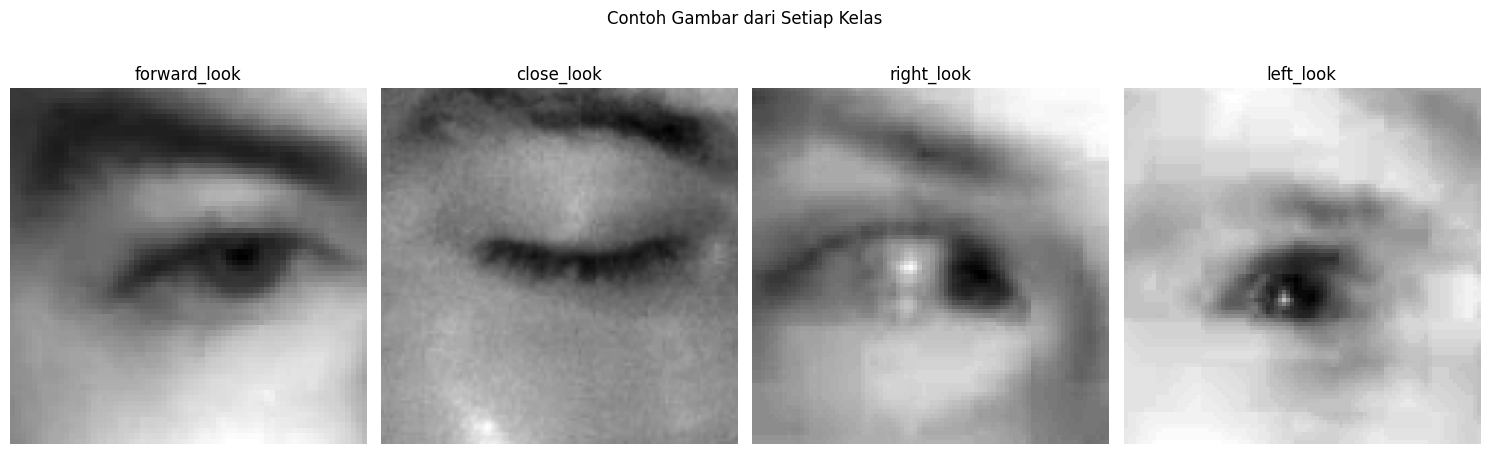

In [20]:
#Melihat sampel gambar
def show_example_images(base_path):
    class_images = {}

    # Cari satu gambar acak dari setiap subfolder (kelas)
    for root, dirs, files in os.walk(base_path):
        if root == base_path:
            continue
        class_name = os.path.basename(root)
        if files:
            random_image = random.choice(files)
            class_images[class_name] = os.path.join(root, random_image)

    # Plot semua gambar
    fig, axes = plt.subplots(1, len(class_images), figsize=(15, 5))
    fig.suptitle('Contoh Gambar dari Setiap Kelas')

    if len(class_images) == 1:
        axes = [axes]

    for ax, (class_name, image_path) in zip(axes, class_images.items()):
        img = Image.open(image_path)
        ax.imshow(img.convert('L'), cmap='gray')
        ax.set_title(class_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Path ke folder utama sebelum split (berisi semua gambar)
base_path = "/content/eye_dataset/Eye dataset/"
show_example_images(base_path)

# Dataset Dibagi Menjadi Train Set, Test Set dan Validation Set.

In [7]:
# Spil dataset menjadi data train, validation dan testing
def split_dataset(base_path, train_ratio=0.8, val_ratio=0.1, seed=42):
    random.seed(seed)
    class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))
                  and d not in ['train', 'val', 'test']]

    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(base_path, split), exist_ok=True)

    for class_name in class_dirs:
        class_path = os.path.join(base_path, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)
        n_test = n_total - n_train - n_val

        split_counts = {
            'train': images[:n_train],
            'val': images[n_train:n_train+n_val],
            'test': images[n_train+n_val:]
        }

        for split, split_images in split_counts.items():
            dest_dir = os.path.join(base_path, split, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            for img in split_images:
                shutil.move(os.path.join(class_path, img), os.path.join(dest_dir, img))

        # Hapus folder original jika kosong
        if not os.listdir(class_path):
            os.rmdir(class_path)

    print("✅ Dataset telah berhasil dibagi menjadi train, val, dan test.")

# Contoh pemanggilan
split_dataset("/content/eye_dataset/Eye dataset/")

✅ Dataset telah berhasil dibagi menjadi train, val, dan test.


In [8]:
# Generator untuk data pelatihan (dapat ditambahkan augmentasi)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Generator untuk validasi dan test (tanpa augmentasi, hanya rescale)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/eye_dataset/Eye dataset/train', target_size=(60, 60),
    color_mode='grayscale', batch_size=32, class_mode='categorical', shuffle=True)

val_generator = val_test_datagen.flow_from_directory(
    '/content/eye_dataset/Eye dataset/val', target_size=(60, 60),
    color_mode='grayscale', batch_size=32, class_mode='categorical', shuffle=False)

test_generator = val_test_datagen.flow_from_directory(
    '/content/eye_dataset/Eye dataset/test', target_size=(60, 60),
    color_mode='grayscale', batch_size=32, class_mode='categorical', shuffle=False)

Found 11486 images belonging to 4 classes.
Found 1433 images belonging to 4 classes.
Found 1441 images belonging to 4 classes.


# Model Sequential, Conv2D, Pooling Layer

In [9]:
# Membuat model CNN dengan arsitektur yang sudah ditentukan
cnn_model = Sequential([
    # Lapisan konvolusi pertama
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(60, 60, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),  # Lapisan pooling untuk mengurangi ukuran fitur
    layers.Dropout(0.3),  # Mengurangi overfitting dengan menggunakan dropout

    # Lapisan konvolusi kedua
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),  # Lapisan pooling untuk mengurangi ukuran fitur
    layers.Dropout(0.3),  # Mengurangi overfitting dengan menggunakan dropout

    # Lapisan konvolusi ketiga
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),  # Lapisan pooling untuk mengurangi ukuran fitur
    layers.Dropout(0.3),  # Mengurangi overfitting dengan menggunakan dropout

    layers.Flatten(),  # Mengubah output 2D menjadi 1D untuk diteruskan ke lapisan dense
    layers.Dense(512, activation='relu'),  # Lapisan dense dengan 512 neuron
    layers.Dropout(0.3),  # Mengurangi overfitting dengan menggunakan dropout
    layers.Dense(4, activation='softmax')  # Lapisan output untuk klasifikasi multi-kelas (4 kelas)
])

# Menyusun model dengan optimizer, fungsi loss, dan metrik evaluasi
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Menampilkan ringkasan arsitektur model
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 58, 58, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       410,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,980 (1.64 MB)

 Trainable params: 430,980 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

# Mengecek Akurasi pada Training dan Testing Set

In [10]:
# Menentukan direktori untuk menyimpan log TensorBoard
log_directory = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_directory)

# Membuat checkpoint untuk menyimpan model terbaik
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Mengatur early stopping untuk mencegah overfitting
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True )

# Menggabungkan semua callback ke dalam satu daftar
callbacks_list = [tensorboard_callback, model_checkpoint, early_stopping_callback]

# Melatih model dengan data yang telah dipersiapkan
training_history = cnn_model.fit(
    train_generator,
    epochs=35,
    validation_data=val_generator,
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
359/359 ━━━━━━━━━━━━━━━━━━━━ 86s 202ms/step - accuracy: 0.3963 - loss: 1.2508 - val_accuracy: 0.7809 - val_loss: 0.7733
Epoch 2/35
359/359 ━━━━━━━━━━━━━━━━━━━━ 65s 182ms/step - accuracy: 0.6686 - loss: 0.7987 - val_accuracy: 0.8388 - val_loss: 0.5703
Epoch 3/35
359/359 ━━━━━━━━━━━━━━━━━━━━ 65s 181ms/step - accuracy: 0.7104 - loss: 0.6961 - val_accuracy: 0.8548 - val_loss: 0.4641
Epoch 4/35
359/359 ━━━━━━━━━━━━━━━━━━━━ 66s 183ms/step - accuracy: 0.7543 - loss: 0.6067 - val_accuracy: 0.8918 - val_loss: 0.4097
Epoch 5/35
359/359 ━━━━━━━━━━━━━━━━━━━━ 67s 185ms/step - accuracy: 0.7808 - loss: 0.5516 - val_accuracy: 0.9218 - val_loss: 0.3782
Epoch 6/35
359/359 ━━━━━━━━━━━━━━━━━━━━ 65s 181ms/step - accuracy: 0.8123 - loss: 0.4953 - val_accuracy: 0.9428 - val_loss: 0.3048
Epoch 7/35
359/359 ━━━━━━━━━━━━━━━━━━━━ 66s 184ms/step - accuracy: 0.8259 - loss: 0.4626 - val_accuracy: 0.9456 - val_loss: 0.2904
Epoch 8/35
359/359 ━━━━━━━━━━━━━━━━━━━━ 66s 183ms/step - accuracy: 0.8411 - loss: 0

In [ ]:
# --- Akurasi Training Terbaik ---
best_train_acc = max(training_history.history['accuracy'])
print(f"Akurasi Training Terbaik: {best_train_acc:.4f}")

# --- Akurasi Validasi Terbaik ---
best_val_acc = max(training_history.history['val_accuracy'])
print(f"Akurasi Validasi Terbaik: {best_val_acc:.4f}")

# --- Evaluasi Akurasi Testing ---
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"Akurasi Testing: {test_acc:.4f}")

Akurasi Training Terbaik: 0.9548
Akurasi Validasi Terbaik: 0.9805
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9852 - loss: 0.0585
Akurasi Testing: 0.9778


# Plot Terhadap Akurasi dan Loss Model

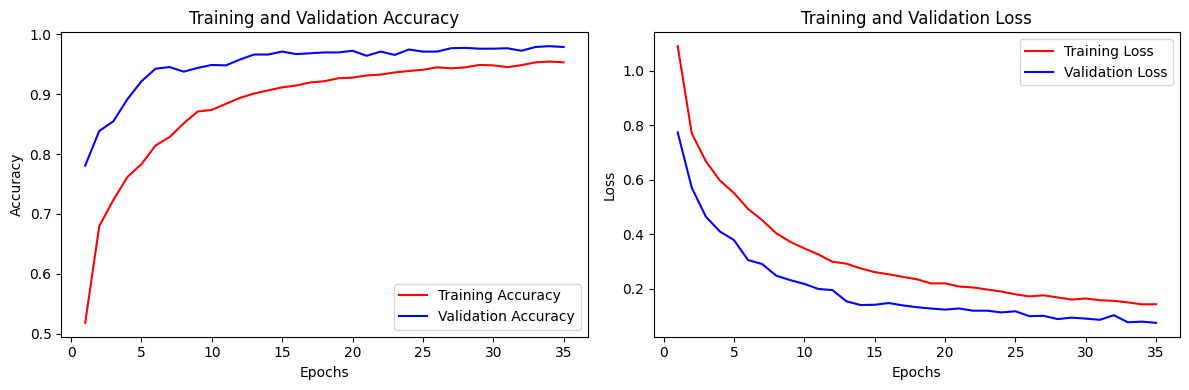

In [12]:

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi setelah training selesai
plot_training_history(training_history)

# Menyimpan Model ke Dalam Format SavedModel, TF-Lite dan TFJS

In [ ]:
# ===== 1. Simpan Model ke Format SavedModel (Keras 3) =====
# Pastikan model yang digunakan sudah terlatih
path_simpan_model = "/content/cnn_saved_model/"
cnn_model.export(path_simpan_model) 

# ===== 2. Konversi ke TensorFlow Lite =====
konverter_tflite = tf.lite.TFLiteConverter.from_saved_model(path_simpan_model)
model_dalam_tflite = konverter_tflite.convert()

# Simpan model TFLite ke file
with open('/content/cnn_model_lite.tflite', 'wb') as simpan_file:
    simpan_file.write(model_dalam_tflite)

class_labels = ['normal', 'cataract', 'glaucoma', 'other'] 
with open('/content/label.txt', 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")

# ===== 3. Konversi ke TensorFlow.js =====
!pip install tensorflowjs -q

# Konversi dengan tensorflowjs_converter
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    /content/cnn_saved_model \
    /content/cnn_model_tfjs

Saved artifact at '/content/cnn_saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 60, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133697501350032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697501360592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697501360976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697501363088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697501361936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697501363856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697501364048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697394509392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697394508816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697394510160: TensorSpec(shape=(), dtype=tf.resource, name=None)
2025-04-1

# Inference Menggunakan SaveModel

Saving Mata.jpg to Mata.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
=== Inference via SavedModel (TFSMLayer) ===
File gambar: Mata.jpg
Predicted Class: forward look
Confidence Scores: [[6.82785100e-08 8.91156614e-01 1.00550175e-01 8.29302426e-03]]


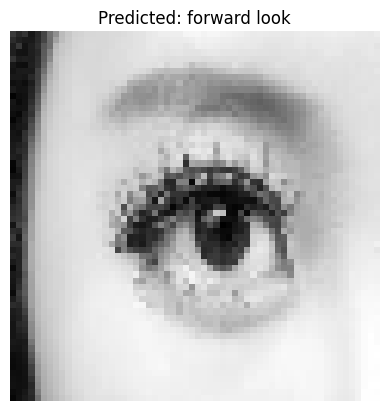

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# 1. Load model via TFSMLayer
saved_model_path = '/content/cnn_saved_model/'
model = Sequential([TFSMLayer(saved_model_path, call_endpoint='serving_default')])

# 2. Upload gambar
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# 3. Preprocessing gambar
img = load_img(img_path, target_size=(60, 60), color_mode='grayscale')
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# 4. Inference
predictions = model.predict(img_array)

# 5. Ambil hasil prediksi
if isinstance(predictions, dict):
    predictions = predictions.get('output_0', None)  

# 6. Interpretasi hasil
class_names = ['close look', 'forward look', 'right look', 'left look']
predicted_class_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_class_index]

# 7. Tampilkan hasil
print("=== Inference via SavedModel (TFSMLayer) ===")
print(f"File gambar: {img_path}")
print(f"Predicted Class: {predicted_class}")
print(f"Confidence Scores: {predictions}")

# Visualisasi gambar
plt.imshow(img_array[0].squeeze(), cmap='gray')
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

# Inference menggunakan TensorFlow Lite (TFLite)

Saving eye_test.jpg to eye_test.jpg
=== Inference via TFLite ===
File Gambar       : eye_test.jpg
Predicted Class   : close look
Confidence Scores : [[0.52306694 0.20389938 0.02012765 0.25290596]]


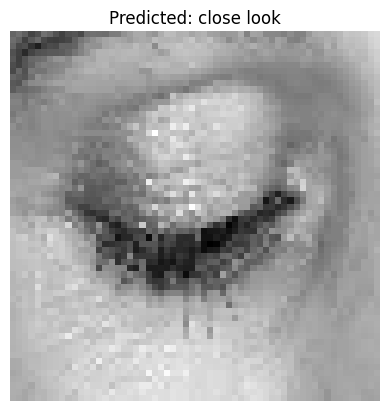

In [ ]:
# ===== 1. Load Model TFLite =====
tflite_model_path = '/content/cnn_model_lite.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# ===== 2. Upload Gambar =====
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# ===== 3. Preprocessing Gambar =====
img = load_img(img_path, target_size=(60, 60), color_mode='grayscale')
img_array = img_to_array(img) / 255.0  
img_array = np.expand_dims(img_array, axis=0).astype(np.float32)  

# ===== 4. Inference =====
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

# ===== 5. Ambil Prediksi =====
predictions = interpreter.get_tensor(output_details[0]['index'])
class_names = ['close look', 'forward look', 'right look', 'left look']
predicted_class_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_class_index]

# ===== 6. Tampilkan Hasil =====
print("=== Inference via TFLite ===")
print(f"File Gambar       : {img_path}")
print(f"Predicted Class   : {predicted_class}")
print(f"Confidence Scores : {predictions}")

# Visualisasi
plt.imshow(img_array[0].squeeze(), cmap='gray')
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

In [17]:
!pip freeze > requirements.txt
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
submission_folder = '/content/submission'
os.makedirs(submission_folder, exist_ok=True)

# Salin TFJS model
shutil.copytree('/content/cnn_model_tfjs', os.path.join(submission_folder, 'tfjs_model'))

# Salin TFLite model
os.makedirs(os.path.join(submission_folder, 'tflite'), exist_ok=True)
shutil.copy('/content/cnn_model_lite.tflite', os.path.join(submission_folder, 'tflite/model.tflite'))

# Salin label.txt
shutil.copy('/content/label.txt', os.path.join(submission_folder, 'tflite/label.txt'))

# Salin SavedModel
shutil.copytree('/content/cnn_saved_model', os.path.join(submission_folder, 'saved_model'))

'/content/submission/saved_model'

In [19]:
# Kompres folder submission menjadi zip
shutil.make_archive('/content/submission', 'zip', '/content/submission')

# Tampilkan link download
from google.colab import files
files.download('/content/submission.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>